In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import itertools
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### This notebook implement the CNN binary classifier with pre-trained ResNet50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/images_notation_train_test.zip" -d "/content"

### Load dataset

In [ ]:
IMAGE_SIZE = 224
batch_size = 16

# Load training dataset and do some Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.5,
    fill_mode='wrap',
    horizontal_flip=True,
    validation_split=0.2,
    data_format='channels_last')

train_generator = train_datagen.flow_from_directory(
    "/content/images_notation_train_test/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    "/content/images_notation_train_test/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
    )

# Load test images
test_datagen = ImageDataGenerator(
    data_format='channels_last')
test_generator = test_datagen.flow_from_directory(
    "/content/images_notation_train_test/test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='binary'
    )


Found 2766 images belonging to 2 classes.
Found 691 images belonging to 2 classes.
Found 866 images belonging to 2 classes.


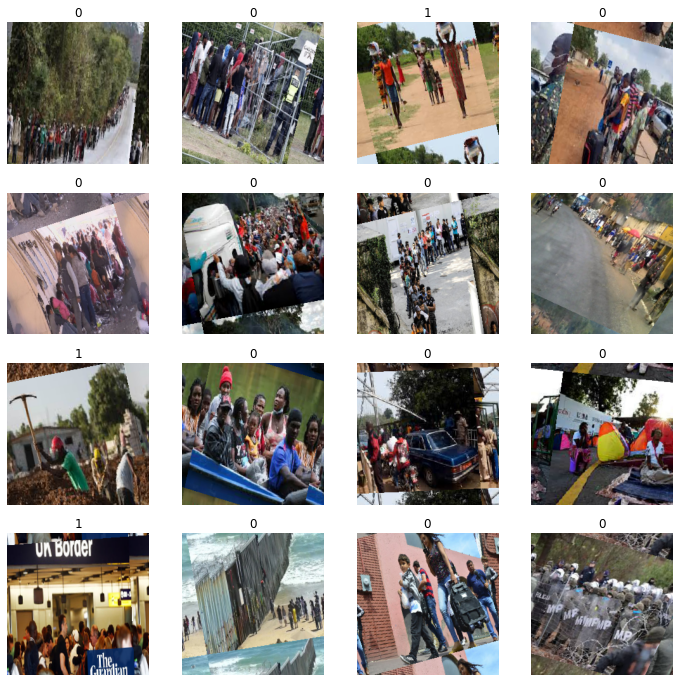

In [ ]:
# Display example of the training images after data augmentation
fig = plt.figure(figsize=(12, 12))

img, label = train_generator.next() 

for i in range(16):
  ax = plt.subplot(4,4,i+1)
  ax.axis('off')
  ax.set_title(int(label[i]))
  ax.imshow(np.uint8(img[i]))
plt.show()


### Build basice cnn binary classifier with pre-trained ResNet50

In [ ]:
def build_model():
  #Load weights pre-trained on ImageNet
  base_model = ResNet50(
    weights="imagenet",  
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False) 

  # Freeze the base_ model
  base_model.trainable = False
  inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  x = inputs
  inputs_pp = tf.keras.applications.resnet50.preprocess_input(x)
  x = base_model(inputs_pp, training=False)

  # add the top layers to the model
  x = keras.layers.GlobalAveragePooling2D()(x)
  xx = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(xx)  
  model = keras.Model(inputs, outputs)
  # model.summary()
  return model

# display the training history
def plot_hist(hist):
    plt.figure()
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history["val_binary_accuracy"])
    plt.title("Training and Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc=0)
    plt.show()

    plt.figure()
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training and Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc=0)
    plt.show()


def predict_dataset(test_ds, model):
    test_ds_labels = []
    test_ds_images = []
    for images, labels in test_ds.unbatch():
        test_ds_images.append(images.numpy())
        test_ds_labels.append(labels.numpy())

    x = np.array(test_ds_images)
    pred_val = model.predict(x, verbose=1)

    m = keras.metrics.BinaryAccuracy()
    m.update_state(test_ds_labels, pred_val)
    accuracy = m.result().numpy()
    print("Test data BinaryAccuracy is: ", accuracy)

    pred_test_class = (pred_val > 0.5).astype(int)
    get_confusion_matrix(pred_test_class, test_ds_labels)
    # return accuracy


def get_confusion_matrix(pred_class, true_class):
    cm = tf.math.confusion_matrix(true_class, pred_class, num_classes=2)
    cm = np.array(cm)
    print("confusion_matrix is :")
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix of Binary CNN Classifier")
    plt.colorbar()

    classes = ["immigration", "non-immigration"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    correct_num = 0
    for k in range(cm.shape[0]):
        print(classes[k], "accuracy is: ", cm[k, k] / np.sum(cm[k, :]))
        correct_num += cm[k, k]

    print("Total accuracy is :", correct_num / np.sum(cm))

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()

### Training the basice model and save the best model  

Epoch 1/15
173/173 [==============================] - 50s 276ms/step - loss: 0.6001 - binary_accuracy: 0.7017 - val_loss: 0.4905 - val_binary_accuracy: 0.7699
Epoch 2/15
173/173 [==============================] - 47s 274ms/step - loss: 0.5117 - binary_accuracy: 0.7581 - val_loss: 0.5396 - val_binary_accuracy: 0.7453
Epoch 3/15
173/173 [==============================] - 46s 268ms/step - loss: 0.4764 - binary_accuracy: 0.7701 - val_loss: 0.4638 - val_binary_accuracy: 0.7873
Epoch 4/15
173/173 [==============================] - 53s 307ms/step - loss: 0.4730 - binary_accuracy: 0.7780 - val_loss: 0.4609 - val_binary_accuracy: 0.7887
Epoch 5/15
173/173 [==============================] - 46s 266ms/step - loss: 0.4514 - binary_accuracy: 0.7896 - val_loss: 0.4641 - val_binary_accuracy: 0.7771
Epoch 6/15
173/173 [==============================] - 46s 267ms/step - loss: 0.4570 - binary_accuracy: 0.7867 - val_loss: 0.4524 - val_binary_accuracy: 0.7844
Epoch 7/15
173/173 [==========================

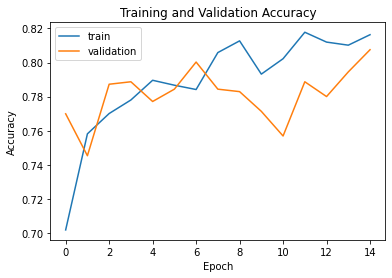

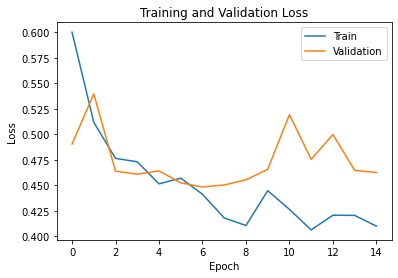

In [ ]:
new_model = build_model()

# Train the top layer
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=[keras.metrics.BinaryAccuracy()])

callbacks = [keras.callbacks.ModelCheckpoint('save_baseline_model.h5', monitor='val_loss', 
                                            save_best_only=True, mode='min')]
epochs = 15
history = new_model.fit(train_generator, epochs=epochs, 
                        validation_data=validation_generator, callbacks=callbacks)

plot_hist(history)


In [ ]:
# Evaluate the performance of the classifier, display the confusion matrix
def predict_generator(test_generator, model):
    test_ds_labels = []
    test_ds_images = []
    total_images = test_generator.n
    steps = total_images // batch_size
    posi_count = 0
    nega_count = 0
    for i in range(steps+1):
      images, labels = test_generator.next()
      for img, label in zip(images, labels):
        test_ds_images.append(img)
        test_ds_labels.append(label)
        if label == 0:
          posi_count += 1
        if label == 1:
          nega_count += 1

    print('total_images = ',total_images)
    print('posi_count = ', posi_count)
    print('nega_count = ', nega_count)

    x = np.array(test_ds_images)
    pred_val = model.predict(x, verbose=1)

    m = keras.metrics.BinaryAccuracy()
    m.update_state(test_ds_labels, pred_val)
    accuracy = m.result().numpy()
    print("Test data BinaryAccuracy is: ", accuracy)

    pred_test_class = (pred_val > 0.5).astype(int)
    get_confusion_matrix(pred_test_class, test_ds_labels)



### Fine tune the model with conv5 [143:]

In [ ]:
def unfreeze_base_model_fine_tune():
    base_model = ResNet50(
        weights="imagenet",  # Load weights pre-trained on ImageNet
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False)

    # Freeze the base_ model
    base_model.trainable = False
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    inputs_pp = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(inputs_pp, training=False)

    # Unfreeze the base_ model
    base_model.trainable = True

    # freeze all layers of base_model except the conv5 [143, 155]
    for layer in base_model.layers[:143]:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(x)
    xx = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(xx) 
    model = keras.Model(inputs, outputs)

    # model.summary()

    return model

### Train the fine tune model and save the best one

Epoch 1/15
173/173 [==============================] - 52s 282ms/step - loss: 0.5428 - binary_accuracy: 0.7336 - val_loss: 0.5986 - val_binary_accuracy: 0.7279
Epoch 2/15
173/173 [==============================] - 48s 277ms/step - loss: 0.4620 - binary_accuracy: 0.7896 - val_loss: 0.4609 - val_binary_accuracy: 0.7945
Epoch 3/15
173/173 [==============================] - 48s 278ms/step - loss: 0.4145 - binary_accuracy: 0.8091 - val_loss: 0.4331 - val_binary_accuracy: 0.8017
Epoch 4/15
173/173 [==============================] - 48s 276ms/step - loss: 0.3729 - binary_accuracy: 0.8344 - val_loss: 0.4937 - val_binary_accuracy: 0.7815
Epoch 5/15
173/173 [==============================] - 48s 277ms/step - loss: 0.3707 - binary_accuracy: 0.8308 - val_loss: 0.4817 - val_binary_accuracy: 0.8046
Epoch 6/15
173/173 [==============================] - 48s 277ms/step - loss: 0.3249 - binary_accuracy: 0.8612 - val_loss: 0.5077 - val_binary_accuracy: 0.7945
Epoch 7/15
173/173 [==========================

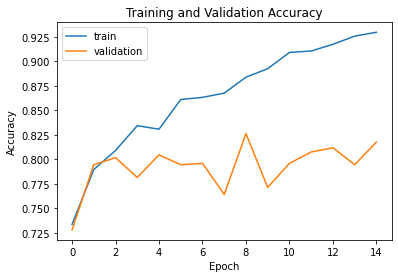

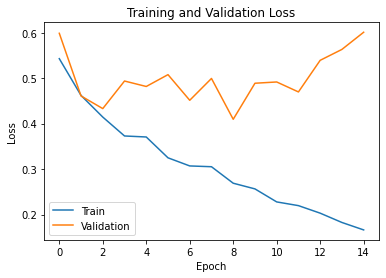

27/27 [==============================] - 2s 55ms/step
Test data BinaryAccuracy is:  0.7964706
confusion_matrix is :
[[215 117]
 [ 56 462]]
immigration accuracy is:  0.6475903614457831
non-immigration accuracy is:  0.8918918918918919
Total accuracy is : 0.7964705882352942


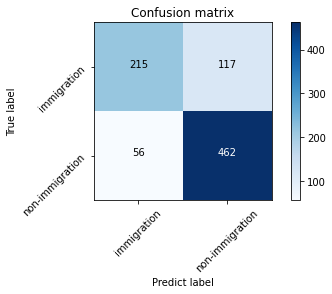

In [ ]:
new_model = unfreeze_base_model_fine_tune()
# Train the top layer
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=[keras.metrics.BinaryAccuracy()])

callbacks = [keras.callbacks.ModelCheckpoint('save_fine_tune_model.h5', monitor='val_loss', 
                                            save_best_only=True, mode='min')]
epochs = 15
history = new_model.fit(train_generator, epochs=epochs, 
                        validation_data=validation_generator, callbacks=callbacks)

plot_hist(history)
predict_generator(test_generator, new_model)

### Load the best model and evaluate the model on the test data 

27/27 [==============================] - 12s 54ms/step
Test data BinaryAccuracy is:  0.8101852
confusion_matrix is :
[[241  98]
 [ 66 459]]
immigration accuracy is:  0.7109144542772862
non-immigration accuracy is:  0.8742857142857143
Total accuracy is : 0.8101851851851852


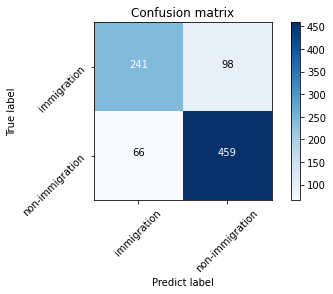

In [ ]:
from keras.models import load_model
model = load_model('/content/save_fine_tune_model.h5')
predict_generator(test_generator, model)

total_images =  866
posi_count =  340
nega_count =  526
28/28 [==============================] - 2s 55ms/step
Test data BinaryAccuracy is:  0.8106236
confusion_matrix is :
[[242  98]
 [ 66 460]]
immigration accuracy is:  0.711764705882353
non-immigration accuracy is:  0.8745247148288974
Total accuracy is : 0.8106235565819861


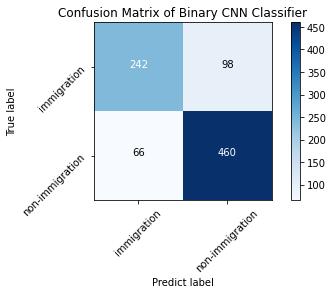

In [ ]:
predict_generator(test_generator, model)

In [ ]:
# precision of the model
242/(242+66)

0.7857142857142857

In [ ]:
# recall of the model
242/(242+98)

0.711764705882353